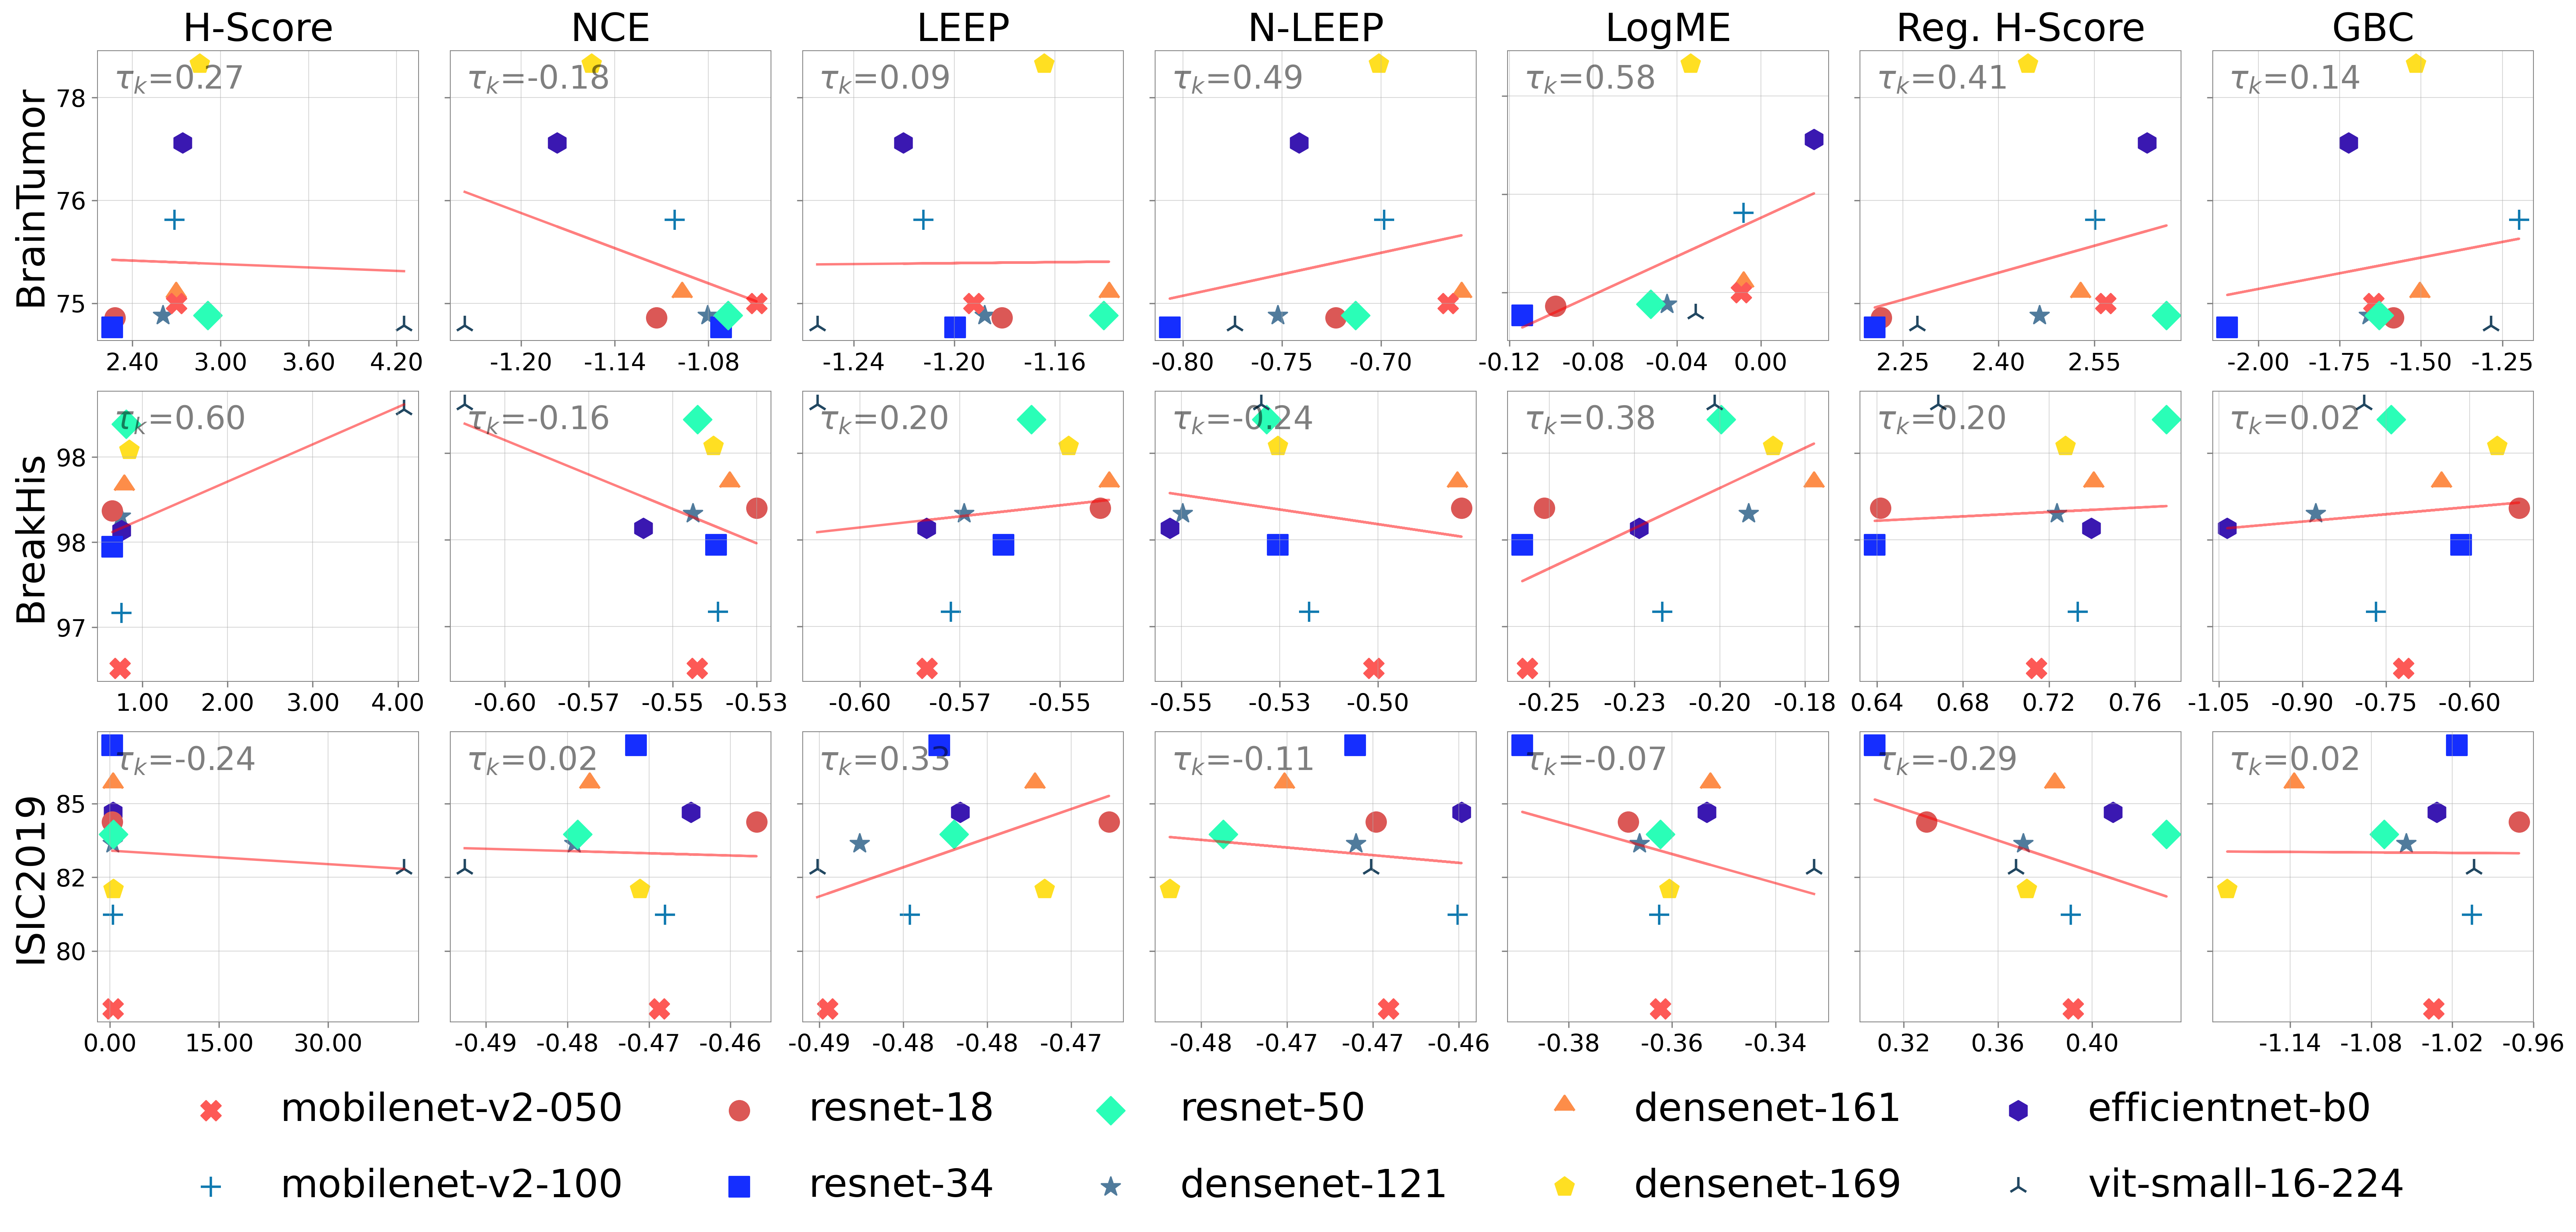

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

from scipy import stats

# read csv containing transferability estimation score
df_models_perf = pd.read_csv('./task_performances.csv')


# read csv containing model's performances on valid and test sets
df_transf_scores = pd.read_csv('./transf_metrics_values.csv')



all_metrics = ['hscore_score',
               'nce_score',
               'leep_score',
               'nleep_score',
               'logme_score',
               'reg_hscore_score',
               'gbc_score']

all_datasets = ['brain_tumor_kaggle',
                'breakhis',
                'skin_splits']
_archs = df_models_perf['model'].unique()
_archs.sort()

markers = {'densenet121': '*',
           'densenet169': 'p',
           'densenet161': 10,
           'mobilenetv2_100': '+',
           'efficientnet_b0': 'h',
           'vit_small_patch16_224': '2',
           'mobilenetv2_050': 'X',
           'resnet34': 's',
           'resnet18': 'o',
           'resnet50': 'D'}
tam = 150

ds_title = {'skin_splits': 'ISIC2019',
           'brain_tumor_kaggle': 'BrainTumor',
           'breakhis': "BreakHis"}

x_axis_name = {'hscore_score': 'H-Score',
               'nce_score': 'NCE',
               'leep_score': 'LEEP',
               'nleep_score': 'N-LEEP',
               'logme_score': 'LogME',
               'reg_hscore_score': 'Reg. H-Score',
               'gbc_score': 'GBC'}


archnames =  {'densenet121':  'densenet-121',
              'densenet169':  'densenet-169',
              'densenet161':  'densenet-161',
              'mobilenetv2_100': 'mobilenet-v2-100',
              'mobilenetv2_050': 'mobilenet-v2-050',
              'efficientnet_b0': 'efficientnet-b0',
              'vit_small_patch16_224': 'vit-small-16-224',
              'resnet34': 'resnet-34',
              'resnet18': 'resnet-18',
              'resnet50': 'resnet-50'}

r, c = len(all_datasets), len(all_metrics)
fig, axs = plt.subplots(r, c, figsize=(22, 9), dpi=300)
for ds_id, ds in enumerate(all_datasets):
    for metric_id, metric in enumerate(all_metrics):
        row_id = ds_id
        col_id = metric_id

        x, y = [], []
        arch_repeated = []
        # para cada modelo
        for _model in _archs:
            # filtra no dataframe adequado o valor do eixo X
            _x = df_transf_scores[(df_transf_scores['task'] == ds) &
                                  (df_transf_scores['model'] == _model) &
                                  (df_transf_scores['metric'] == metric)]['value'].item()
            x.append(_x)

            # filtra no dataframe adequado o valor do eixo X
            _y = df_models_perf[(df_models_perf['model'] == _model) &
                                (df_models_perf['task'] == ds)]['test_acc_score'].item()
            _y *= 100
            y.append(_y)
            arch_repeated.append(_model)

        # coloca as linhas do grid, cores e shape de cada modelo.
        axs[row_id, col_id].grid(visible=True, linewidth=0.5, alpha=0.5)
        for (x_val, y_val, model) in zip(x, y, arch_repeated):
            _c = list(mcolors.XKCD_COLORS)[55 + 20*list(markers.keys()).index(model)]
            axs[row_id, col_id].scatter(x_val,
                                        y_val,
                                        marker=markers[model],
                                        label=archnames[model],
                                        s=tam,
                                        c=_c)

        # ajuste nos titulos dos eixos X e Y
        if row_id == 0:
            axs[row_id, col_id].set_title(f"{x_axis_name[metric]}", fontsize=24)
        if col_id == 0:
            axs[row_id, col_id].set_ylabel(f"{ds_title[ds]}", fontsize=24)
            axs[row_id, col_id].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        else:
            axs[row_id, col_id].set_yticklabels([])

        #plota a reta de regressao na cor vermelha
        slope, intercept = np.polyfit(x, y, 1)
        axs[row_id, col_id].plot(np.array(x), np.array(x)*slope + intercept, color='red', alpha=0.5)

        # Set the frame line width to thin and color to gray
        for _, spine in axs[row_id, col_id].spines.items():
            spine.set_linewidth(0.5)
            spine.set_color('gray')
        axs[row_id, col_id].tick_params(axis='both', labelsize=15, color='gray', labelcolor='black')

        # fixa a quantidade de valores em cada eixo
        axs[row_id, col_id].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[row_id, col_id].yaxis.set_major_locator(plt.MaxNLocator(4))

        # calcula kendall tau
        tau_kt, pval_kt = stats.kendalltau(x, y)
        tau_kt = np.round(tau_kt, 3)
        tr = axs[row_id, col_id].transAxes
        axs[row_id, col_id].text(0.05, 0.90, r"$\tau_k$=" f"{tau_kt:.2f}", fontsize=20, transform=tr,
                                 horizontalalignment='left', verticalalignment='center', color='black',
                                 alpha=0.5)

        # formata eixo em duas casas decimais
        axs[row_id, col_id].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# ajusta a ordem das legendas
handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 5, 6, 7, 8, 0, 1, 2, 3, 9]
# legendas
if len(handles) and len(labels):
    fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
               loc='upper center',
               fancybox=True,
               ncol=5,
               bbox_to_anchor=(0.5, 0.0),
               labelspacing=1.0,
               fontsize=24,
               frameon=False)

# salva a figura
fig.patch.set_facecolor('white')
fig.tight_layout(pad=0, h_pad=1, w_pad=0.1)
plt.show()